In [1]:
import itertools

import pymc3 as pm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
TRACE_LENGTH = 10000

## Same utility functions from last chapter

I know, I know... (DRY it!)

In [3]:
def acf(trace, lag):
    '''
    Autocorrelation function, based on Pearson correlation
    coefficient.
    '''
    correlation, _ = stats.stats.pearsonr(trace[:-lag], trace[lag:])
    return correlation


def ess(trace):
    '''
    Effective sample size, as defined in Kruschke's "Doing
    Bayesian Data Analysis", 2nd edition, p. 184.
    '''
    significant_autocorrelations = []
    for lag in itertools.count(start=1):
        autocorrelation = acf(trace, lag)
        significant_autocorrelations.append(autocorrelation)
        if autocorrelation < 0.05:
            break
    N = len(trace)
    denominator = 1 + 2 * sum(significant_autocorrelations)
    return N / denominator

# Exercise 1

Reading data from csv file: 3 subjects, multiple samples per subject.

Infere the subjects proportion, individually, and compare to each other.

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_yossi, theta_jacob, theta_moshe]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta_moshe,0.477,0.108,0.281,0.683,0.001,0.000,27848.0,26071.0,27906.0,13920.0,1.0
theta_jacob,0.546,0.147,0.274,0.810,0.001,0.001,25383.0,23007.0,25042.0,13568.0,1.0
theta_yossi,0.376,0.119,0.158,0.598,0.001,0.001,27335.0,24855.0,27119.0,13949.0,1.0


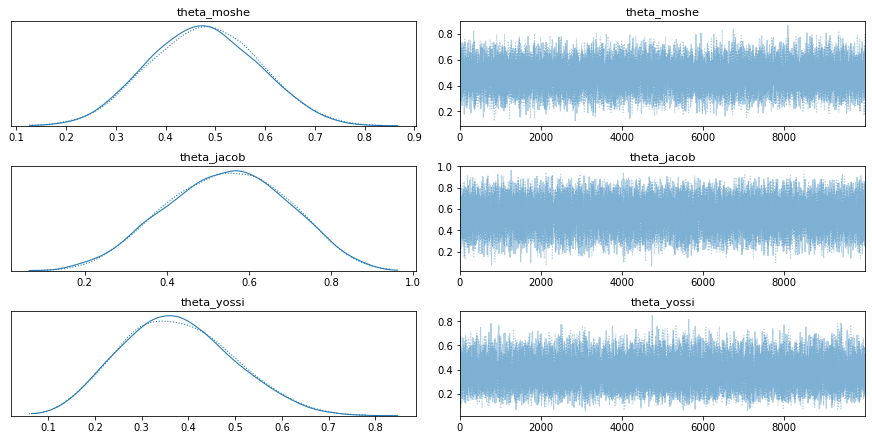

In [4]:
data = pd.read_csv('data/ch08_ex1_demo_data.csv')
# subject,y
# moshe,1
# moshe,1
# jacob,0
# jacob,1
# jacob,1
# yossi,0
# ...

subjects = data.subject.unique()

with pm.Model() as model:

    # Model definition
    for subject in subjects:
        subject_prior = pm.Beta('theta_{}'.format(subject), 2, 2)
        subject_data = data[data.subject == subject].y
        pm.Bernoulli('y_{}'.format(subject), subject_prior,
                     observed=subject_data)

    # Inference
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)  # instantiate sampler
    trace = pm.sample(TRACE_LENGTH, step, start=start)

pm.traceplot(trace)
pm.stats.summary(trace)

Inference of difference between subject proportions.

moshe ess: 28324.232909645747
jacob ess: 27868.61600395425
yossi ess: 29663.791165771545


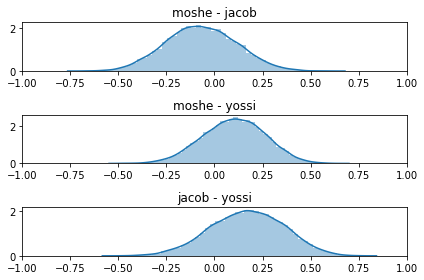

In [5]:
# Per subject effective sample size
for subject in subjects:
    subject_ess = ess(trace.get_values('theta_{}'.format(subject)))
    print('{} ess: {}'.format(subject, subject_ess))

# Subjects bias differences
diffs = {}  # Holds the diff traces
for subj_a, subj_b in itertools.combinations(subjects, 2):
    diff_name = '{} - {}'.format(subj_a, subj_b)
    params = ('theta_{}'.format(subj) for subj in (subj_a, subj_b))
    subj_a_trace, subj_b_trace = (trace.get_values(param) for param in params)
    diffs[diff_name] = subj_a_trace - subj_b_trace

# Plot all the bias differences
plt.figure()
for i, (diff_name, diff_trace) in enumerate(diffs.items(), start=1):
    plt.subplot(len(diffs), 1, i)
    sns.distplot(diff_trace)
    plt.title(diff_name)
    plt.xlim([-1, 1])
plt.tight_layout()

# Exercise 4

Explore different priors, using MCMC.

Priors are that the paramaters are both beta distributed, but with different beta distribution arguments.

In [6]:
def explore_prior(theta_a_params, theta_b_params):
    with pm.Model() as model:
        # Model definition
        theta_a = pm.Beta('theta_a', *theta_a_params)
        theta_b = pm.Beta('theta_b', *theta_b_params)

        # Sampling the prior
        step = pm.NUTS()
        trace = pm.sample(TRACE_LENGTH, step)

    data = pd.DataFrame({t: trace.get_values(t) for t in ('theta_a', 'theta_b')})

    # Plot
    sns.jointplot('theta_a', 'theta_b', data, kind="hex", stat_func=None)

    plt.figure()
    sns.distplot(data['theta_a'] - data['theta_b'])
    plt.suptitle('theta_a - theta_b')

## Question A

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_b, theta_a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 7 seconds.


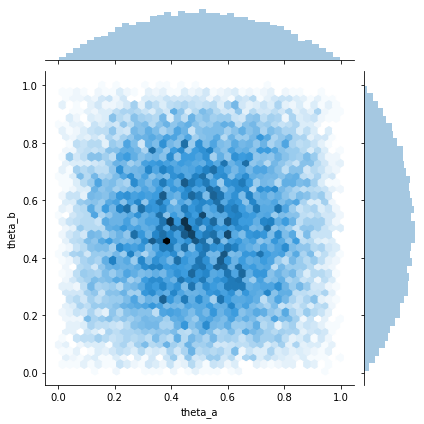

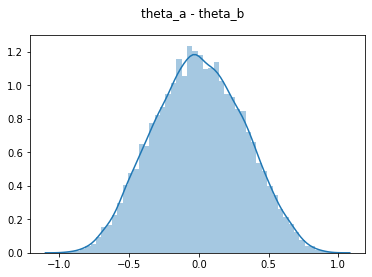

In [7]:
explore_prior(theta_a_params=(2, 2), theta_b_params=(2, 2))

## Question B

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_b, theta_a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.


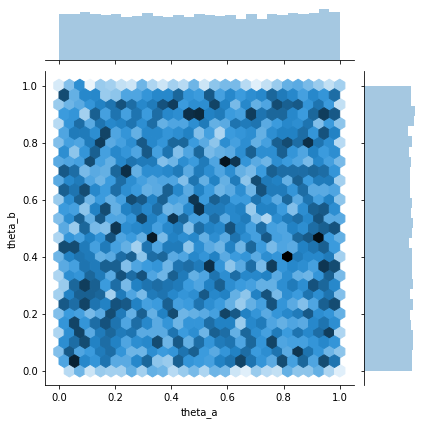

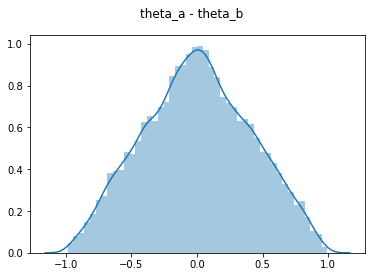

In [8]:
explore_prior(theta_a_params=(1, 1), theta_b_params=(1, 1))

## Question C

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_b, theta_a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


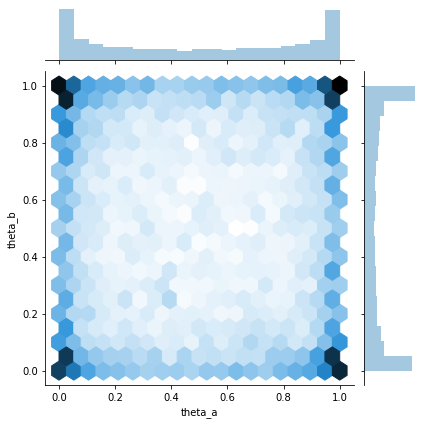

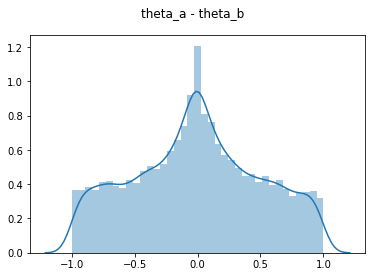

In [9]:
explore_prior(theta_a_params=(.5, .5), theta_b_params=(.5, .5))